## train the model 

In [1]:
import pickle
from ppp_prediction import transtab
import pandas as pd

total_save_dict = pickle.load(open("result/dl/transtab/data/ALL/total.pkl", "rb"))

allset = total_save_dict["allset"]
trainset = total_save_dict["trainset"]
valset = total_save_dict["valset"]
testset = total_save_dict["testset"]
cat_cols = total_save_dict["cat_cols"]
num_cols = total_save_dict["num_cols"]
bin_cols = total_save_dict["bin_cols"]

In [2]:
from torch.utils.data import WeightedRandomSampler
from sklearn.utils import class_weight
import numpy as np


def createWeightedSampler(labels, class_num=2):

    if isinstance(labels, pd.Series):
        labels = labels.values

    class_weights = dict(
        enumerate(
            class_weight.compute_class_weight(
                "balanced",
                classes=np.arange(class_num),
                y=labels,
            )
        )
    )
    print(class_weights)
    train_class_weights = [class_weights[i] for i in labels]
    sampler = WeightedRandomSampler(
        train_class_weights, len(train_class_weights), replacement=True
    )
    return sampler


sampler = createWeightedSampler(trainset[1])

{0: 0.5293663628344605, 1: 9.013141426783479}


In [3]:
model = transtab.build_classifier(cat_cols, num_cols, bin_cols)

# specify training arguments, take validation loss for early stopping
training_arguments = {
    "num_epoch": 100,
    "eval_metric": "val_loss",
    "eval_less_is_better": True,
    "output_dir": "result/dl/transtab/model/ProteinRS",
    "sampler": sampler,
}

/home/xutingfeng/miniforge3/envs/rapids-24.02/lib/python3.10/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer was not TransformerEncoderLayer
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [4]:
transtab.train(model, trainset, valset, **training_arguments)

Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

Output()

/home/xutingfeng/ukb/project/ppp_prediction/ppp_prediction/transtab/trainer.py:114: TqdmExperimentalWarning: rich is experimental/alpha
  for data in tqdm(self.trainloader_list[dataindex]):


In [5]:
import torch
import numpy as np


def predict(
    clf,
    x_test,
    y_test=None,
    return_loss=False,
    eval_batch_size=256,
):
    """Make predictions by TransTabClassifier.

    Parameters
    ----------
    clf: TransTabClassifier
        the classifier model to make predictions.

    x_test: pd.DataFrame
            input tabular data.

    y_test: pd.Series
        target labels for input x_test. will be ignored if ``return_loss=False``.

    return_loss: bool
        set True will return the loss if y_test is given.

    eval_batch_size: int
        the batch size for inference.

    Returns
    -------
    pred_all: np.array
        if ``return_loss=False``, return the predictions made by TransTabClassifier.

    avg_loss: float
        if ``return_loss=True``, return the mean loss of the predictions made by TransTabClassifier.

    """
    clf.eval()
    pred_list, loss_list = [], []
    for i in range(0, len(x_test), eval_batch_size):
        bs_x_test = x_test.iloc[i : i + eval_batch_size]
        if y_test is not None:
            bs_y_test = y_test.iloc[i : i + eval_batch_size]
        with torch.no_grad():
            if y_test is not None:
                logits, loss = clf(bs_x_test, bs_y_test)
            else:
                logits, loss = clf(bs_x_test)

        if loss is not None:
            loss_list.append(loss.item())
        if logits.shape[-1] == 1:  # binary classification
            pred_list.append(logits.sigmoid().detach().cpu().numpy())
        else:  # multi-class classification
            pred_list.append(torch.softmax(logits, -1).detach().cpu().numpy())
    pred_all = np.concatenate(pred_list, 0)
    if logits.shape[-1] == 1:
        pred_all = pred_all.flatten()

    if return_loss:
        avg_loss = np.mean(loss_list)
        return avg_loss
    else:
        return pred_all

In [6]:
model.load("./checkpoint")

x_test, y_test = testset

y_pred = predict(model, x_test)

RuntimeError: Error(s) in loading state_dict for TransTabClassifier:
	size mismatch for input_encoder.feature_processor.word_embedding.word_embeddings.weight: copying a param with shape torch.Size([2916, 128]) from checkpoint, the shape in current model is torch.Size([2919, 128]).

: 

{'AUC': 0.7551839093465423,
 'ACC': 0.6991561457447505,
 'Macro_F1': 0.5052694028348362,
 'Sensitivity': 0.6787878787878788,
 'Specificity': 0.7003872216844143,
 'APR': 0.15471036197104648}

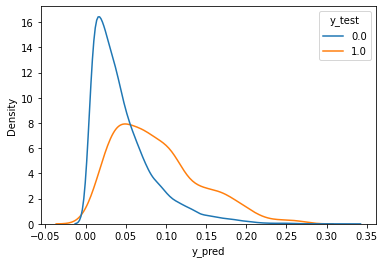

In [ ]:
import pandas as pd
import seaborn as sns

sns.kdeplot(
    pd.DataFrame({"y_pred": y_pred, "y_test": y_test}),
    x="y_pred",
    hue="y_test",
    common_norm=False,
)
from ppp_prediction.corr import cal_binary_metrics

cal_binary_metrics(y_test.values, y_pred)

In [ ]:
y_pred

array([0.0096304 , 0.01932999, 0.04352001, ..., 0.03718373, 0.08343857,
       0.01284842], dtype=float32)

{'AUC': 0.7486046248775498,
 'ACC': 0.6524812766850984,
 'Macro_F1': 0.4835577752550346,
 'Sensitivity': 0.726813880126183,
 'Specificity': 0.6481529512023416,
 'APR': 0.14372086625106173}